# Amazon Reviews for SA fine-grained 5 clases CSV


In [7]:
import seaborn as sb
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


pd.options.mode.chained_assignment = None
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joaoa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset


In [10]:
train_df = pd.read_csv('../docs/train.csv').dropna()
test_df = pd.read_csv('../docs/test.csv').dropna()

Empty DataFrame
Columns: [class_index, review_title, review_text]
Index: []


In [12]:
# Shorten the number of samples from every class_index type (n = 200000)

classes = []
n_samples = 20000

for i in range(1, 6):
    classes.append(train_df.query(f'class_index == {i}').sample(n=n_samples))

train_df_s = pd.concat(classes)
train_df_s.reset_index(drop=True, inplace=True)


## Exploratory analysis


In [11]:
# checking for presence of null values that might interfere with data processing
train_df.isna().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

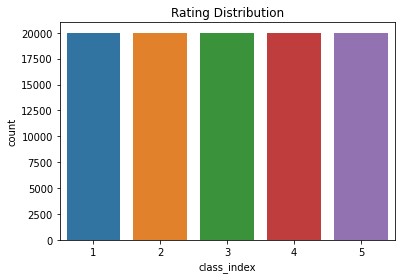

In [17]:
sb.countplot(x='class_index', data=train_df_s)
plt.title('Rating Distribution')


## Preprocess data


In [13]:
train_df_s['review_full'] = train_df_s['review_title']

stop_words = set(nltk.corpus.stopwords.words('english'))

stemmer = PorterStemmer()

# traversing all dataframe's rows
for i in range(train_df_s.shape[0]):

    # process review's title
    title = re.sub('[^a-zA-Z]', ' ', train_df_s['review_title'][i])
    title_tokens = word_tokenize(title)
    title_stems = [stemmer.stem(w) for w in title_tokens if w not in stop_words] 
    train_df_s['review_title'][i] = ' '.join(title_stems)

    # process review's text
    text = re.sub("[^a-zA-Z]", " ", train_df_s['review_text'][i])
    text_tokens = word_tokenize(text)
    text_stems = [stemmer.stem(w) for w in text_tokens if w not in stop_words]
    train_df_s['review_text'][i] = ' '.join(text_stems)

    train_df_s['review_full'][i] = f"{train_df_s['review_title'][i]} {train_df_s['review_text'][i]}"


In [18]:
train_df_s


,class_index,review_title,review_text,review_full
0,1,liter dummi,don wast money seri if realli interest get lib...,liter dummi don wast money seri if realli inte...
1,1,damp document,i angri product i notic document damp i keep p...,damp document i angri product i notic document...
2,1,forget thi book,if look well organ effect tool increas read sp...,forget thi book if look well organ effect tool...
3,1,stickmen,thi movi realli stink pool shoot realli stink ...,stickmen thi movi realli stink pool shoot real...
4,1,spew steam gooey water counter,thi danger counter top applianc due steam spew...,spew steam gooey water counter thi danger coun...
...,...,...,...,...
99995,5,minut chord love,innov sound manipul they pave way artist like ...,minut chord love innov sound manipul they pave...
99996,5,amaz fighter,think game awesom good depth right fun far one...,amaz fighter think game awesom good depth righ...
99997,5,so far i love condit have yet finish though,those you fan steven king definit get one one ...,so far i love condit have yet finish though th...
99998,5,mind bogglin realiti,i well pleas servic i receiv well content book...,mind bogglin realiti i well pleas servic i rec...


## Machine Learning

### Train test split

In [14]:
corpus = train_df_s['review_full']

X = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer())
]).fit_transform(corpus)
y = train_df_s['class_index']


# 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### Naive Bayes


Test score:  0.4569
Real values
 61400    4
36105    2
51166    3
13317    1
74551    4
        ..
90175    5
20418    2
83425    5
18943    1
90505    5
Name: class_index, Length: 20000, dtype: int64
Predictions
 [2 2 2 ... 1 1 4]


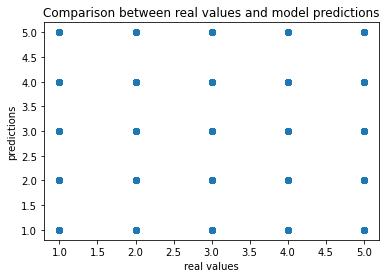

In [15]:
mnb_model = MultinomialNB().fit(X_train, y_train)
y_pred = mnb_model.predict(X_test)

test_score = mnb_model.score(X_test, y_test)
print('Test score: ', test_score)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Comparison between real values and model predictions')
plt.xlabel('real values')
plt.ylabel('predictions')

print('Real values\n', y_test)
print('Predictions\n', y_pred)


### Decision Tree


In [16]:
dtc_model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
test_score = mnb_model.score(X_test, y_test)
print(accuracy_score(y_test, y_pred))
print('Test score: ', test_score)


0.3459
Test score:  0.4569


### Neural Networks
